# Week 7: Non-context-free languages

In [1]:
from tock import *

## Tuesday

Today we're going to talk about how to show that languages are not context-free. There are two canonical examples of non-context-free languages:

\begin{align*}
B &= \{ \mathtt{a}^n \mathtt{b}^n \mathtt{c}^n \mid n \geq 0 \} \\
D &= \{ ww \mid w \in \{ \mathtt{0}, \mathtt{1} \}^\ast \}.
\end{align*}

<div class="alert alert-info">
    <p><b>Read</b> Section 2.3.</p>
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=246e64d6-0d7e-4255-8f9c-ac33015f2af2">W6E1: Prologue to the Pumping Lemma</a>.</p>
</div>

### Another pumping lemma

The pumping lemma for context-free languages is a little more complicated than the pumping lemma for regular languages (even though it actually predates it). 

Remember that in the regular pumping lemma, we looked for a repeated state, and the cycle between the two visits to that state could be repeated 0 or 2 times ($xz$ or $xyyz$) to obtain a string that the DFA must accept. In the context-free pumping lemma, we're going to do the same thing, but along a path of the tree. We'll look for a repeated nonterminal symbol $X$, like this:

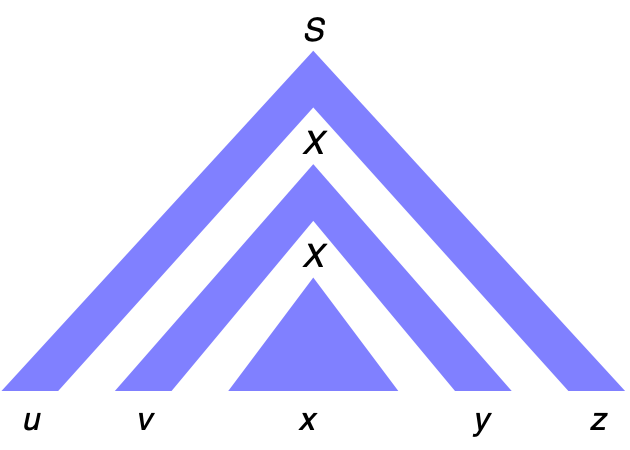

And the slice of the tree in between the two occurrences can be repeated 0 or 2 times, like this:

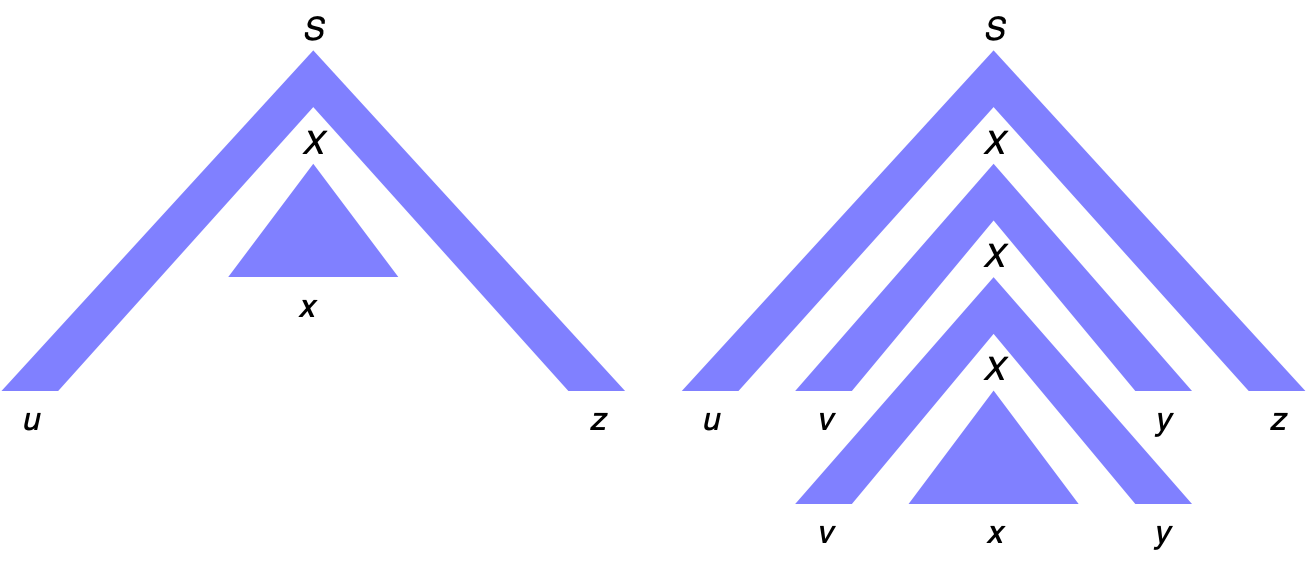

The result is that the pumping now causes *two* pieces of the string to be repeated instead of just one. Also, whereas in the regular pumping lemma, the repeated piece had to be near the beginning of the string, in the context-free pumping lemma, the two pieces have to be near each other, but can occur anywhere in the string. Other than that, writing proofs using the context-free pumping lemma is the same as using the regular pumping lemma.

### As a dialogue

Alice. The language $B=\{\mathtt{a}^n\mathtt{b}^n\mathtt{c}^n\}$ is not context-free.

Bill. Yes it is.

Alice. Do you have a context-free grammar that generates it?

Bill. Yes, here it is:

In [2]:
g = grammars.Grammar.from_lines([
    'A -> a A',
    'A -> a B',
    'B -> b C',
    'C -> B c',
    'C -> c'
])
g

Alice. How many nonterminal symbols does your grammar have?

Bill. Let me count..

In [3]:
v = len(g.nonterminals)
v

3

Alice. What's the maximum length of any right-hand side?

Bill. Let me see...

In [4]:
b = max(len(rhs) for lhs, rhs in g.rules)
b

2

Alice. Does your grammar generate this string?

In [5]:
p = b**(v+1) # you don't have to understand this yet
s = ['a']*(p//3+1) + ['b']*(p//3+1) + ['c']*(p//3+1)
' '.join(s)

'a a a a a a b b b b b b c c c c c c'

Bill. Let me see...

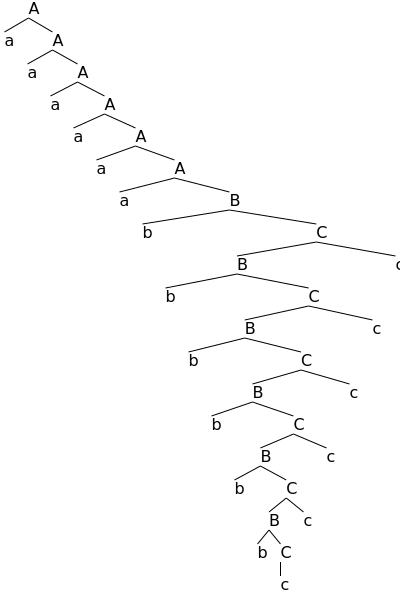

Yes.


In [6]:
try:
    t = grammars.any_parse(g, s)
    display(t)
    print("Yes.")
except Exception:
    print("No.")

Alice. How long is the longest path in the parse tree?

Bill. Let me see...

In [7]:
def longest_path(node):
    if len(node.children) == 0:
        return [node]
    else:
        return max(([node]+longest_path(child) for child in node.children), key=len)
path = longest_path(t)
labels = [node.label for node in path]
' '.join(labels)

'A A A A A A B C B C B C B C B C B C c'

Alice. In this path, you use the same nonterminal twice, right?

Bill. Let me see...

In [8]:
index = {}
for i in reversed(range(len(path))):
    if labels[i] in index:
        n1 = path[i]
        n2 = index[labels[i]]
        break
    index[labels[i]] = path[i]
else:
    assert False
print("Yes.")

Yes.


Alice. Starting from the bottom of the tree, let $n_1$ be the first occurrence of the first repeated nonterminal. And let $n_2$ be the second occurrence of that nonterminal.

Bill. Okay.

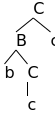

In [9]:
n1

In [10]:
n2

Alice. Let $u$, $v$, $x$, $y$, and $z$ be such that $s = uvxyz$ and $vxy$ is the string under $n_2$ and $x$ is the string under $n_1$.

Bill. Okay.

In [11]:
def leaves(node, foot=None):
    if node == foot:
        return [foot]
    elif len(node.children) == 0:
        return [node.label]
    else:
        result = []
        for child in node.children:
            result.extend(leaves(child, foot))
        return result
def outside(node, foot):
    l = leaves(node, foot)
    i = l.index(foot)
    return l[:i], l[i+1:]

u, z = outside(t, n1)
v, y = outside(n1, n2)
x = leaves(n2)

print('u =', ' '.join(u))
print('v =', ' '.join(v))
print('x =', ' '.join(x))
print('y =', ' '.join(y))
print('z =', ' '.join(z))

u = a a a a a a b b b b b
v = b
x = c
y = c
z = c c c c


Alice. Does your grammar generate this string?

In [12]:
s1 = u + v + v + x + y + y + z
' '.join(s1)

'a a a a a a b b b b b b b c c c c c c c'

Bill. Let me see...

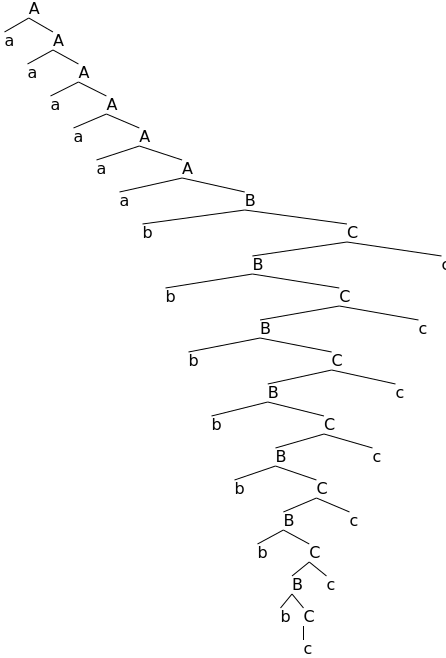

Yes, I lose.


In [13]:
try:
    t1 = grammars.any_parse(g, s1)
except ValueError:
    print("No, I win (this shouldn't happen).")
else:
    display(t1)
    print("Yes, I lose.")

### Statement of the lemma

<div class="alert alert-info">
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=e01e275c-e8c9-4b0d-a9f5-ac34003fccd1">W6E2: The Pumping Lemma</a>.</p>
</div>

Compared to the dialogue for the regular pumping lemma, the dialogue above is more complicated, and Alice's choice of $s$ is somewhat mysterious. But the structure of the dialogue is the same, and likewise the statement of the context-free pumping lemma has the same structure as the regular pumping lemma.

- For any context-free language $A$,
- there exists a $p$ (the pumping length), such that
- for any string $s$ such that $|s| \geq p$,
- there exist $u,v,x,y,z$ such that $s=uvxyz$, $|vy|>0$, $|vxy|\leq p$, and
- for all $i$, $uv^ixy^iz \in A$.

### The pumping length

Recall that in the regular pumping lemma, the pumping length $p$ was just the number of states in the DFA. Thus $p$ symbols was enough to ensure that the DFA went through a loop, and the loop had to occur within the first $p$ symbols. Now, we want to know how many terminals is long enough to ensure that the CFG has a path with a loop.

Let $b$ be the maximum number of symbols in a right hand side of the grammar, which is also the maximum number of children a node can have. Define the *height* of a tree to be the number of *edges* (equivalently, the number of *nonterminals*) in its longest root-to-leaf path. For example, this tree has height 2:

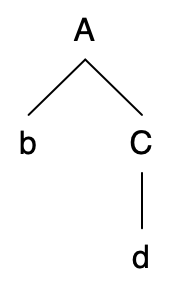

A tree with height 0 has just 1 leaf; a tree with height 1 has at most $b$ leaves; a tree with height 2 has at most $b^2$ leaves, and in general, the largest possible tree with height $h$ has $b^h$ leaves. So we have $|s| \leq b^h$.

Now, we want to guarantee that the tree has a path with a repeated nonterminal, so let's reason backwards from $h \geq |V|+1$. This will be true if $b^h \geq b^{|V|+1}$ (assuming $b > 1$), and we know that $b^h \geq |s|$, so we want $|s| \geq b^{|V|+1}$, so set $p = b^{|V|+1}$. Let's reason forwards again to make sure we got it right: For any string $s$ such that $|s| \geq p = b^{|V|+1}$, we know that $b^h \geq |s| \geq p = b^{|V|+1}$, so $h \geq |V|+1$. So by the pigeonhole principle, there must be a repeated nonterminal on the longest path.

There are two further conditions that we need to guarantee: $|vy|>0$ and $|vxy|\leq p$. The book explains how to prove that both of these conditions must be true; I think this is enough detail for us, though.

### An example proof

<div class="alert alert-info">
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=3a765c2b-53ce-4aa1-a85d-ac340040de42">W6E3: Using the Pumping Lemma</a>.</p>
</div>

Now let's use the pumping lemma to prove the non-context-freeness of language $B$.

Suppose that $B$ is context-free. The pumping lemma gives a length $p$ such that any $s$ with $|s| \geq p$ can be written as $s = uvxyz$, where $|vy|>0$, $|vxy| \leq p$, and for all $i$, $uv^ixy^iz \in B$. Choose $s = \mathtt{a}^p \mathtt{b}^p \mathtt{c}^p$. Then the pumping lemma says that $s' = uxz \in B$, but this is impossible, by the following reasoning. Because $|vxy| \leq p$, there are two cases we must consider.

- If $vxy$ contains only $\mathtt{a}$'s and $\mathtt{b}$'s, then $s'$ contains fewer $\mathtt{a}$'s or $\mathtt{b}$'s than $\mathtt{c}$'s.

- If $vxy$ contains only $\mathtt{b}$'s and $\mathtt{c}$'s, then $s'$ contains fewer $\mathtt{b}$'s or $\mathtt{c}$'s than $\mathtt{a}$'s.

In either case, $s'$ cannot belong to $B$, which is a contradiction. We conclude that $B$ is not context-free.

### Another example

To show: $D = \{ ww \mid w \in \{ \mathtt{0}, \mathtt{1} \}^\ast \}$ is not context-free.

Proof: Suppose that $D$ is context-free. The pumping lemma gives a length $p$ such that any $s$ with $|s| \geq p$ can be written as $s = uvxyz$, where $|vy|>0$, $|vxy| \leq p$, and for all $i$, $uv^ixy^iz \in D$. Choose $s = \mathtt{0}^p \mathtt{1}^p \mathtt{0}^p \mathtt{1}^p$. Then the pumping lemma says that $s' = uxz \in D$, but this is impossible, by the following reasoning. Let's label the parts of $s$ as follows:

$$ \underbrace{\mathtt{0}^p}_{\text{I}} \underbrace{\mathtt{1}^p}_{\text{II}} \underbrace{\mathtt{0}^p}_{\text{III}} \underbrace{\mathtt{1}^p}_{\text{IV}}. $$

- If $vxy$ lies in region I-II: Then $s'=\mathtt{0}^m \mathtt{1}^n \mathtt{0}^p \mathtt{1}^p$ where $m+n < 2p$, so $s'$ can't be of the form $ww$, because its first half ends with a $\mathtt{0}$.
- If $vxy$ lies in region II-III: Then $s'=\mathtt{0}^p \mathtt{1}^m \mathtt{0}^n \mathtt{1}^p$ where $m+n < 2p$. If $m<n$, then the first half of $s'$ ends with a $\mathtt{0}$; if $m>n$, then the second half of $s'$ starts with a $\mathtt{1}$. If $m=n$ then the two halves of $s'$ are not equal.
- If $vxy$ lies in region III-IV: Similar to the first case.

**Question.** Show that $E = \{ \mathtt{a}^m \mathtt{b}^n \mathtt{c}^m \mathtt{d}^n \mid m \geq 0, n \geq 0 \}$ is not context-free.

**Question.** Show that $C = \{\mathtt{a}^i \mathtt{b}^j \mathtt{c}^k \mid 0 \leq i \leq j \leq k\}$ is not context-free.

## Thursday

<div class="alert alert-info">
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=e006e1ca-71a7-4df6-bf46-ac34003fccb2">W6E4: Using Closure Properties</a>.</p>
</div>

### Closure properties

As with proofs of non-regularity, we can often use closure properties to simplify proofs of non-context-freeness or even make proofs possible that would not be possible otherwise. Here's a partial table of closure properties:

| Operation | Regular | Context-free |
|:----------|:--------|:-------------|
| union     | yes     | yes          |
| concatenation | yes | yes          |
| Kleene star | yes   | yes          |
| complementation | yes | **no**     |
| intersection | yes  | **no**       |
| intersection with regular | yes | yes |
| string homomorphism | yes | yes |

The proof of closure under a string homomorphism $\phi$ is very similar to the proof for NFAs, but applied to PDAs: essentially, every transition that reads input $a$ is replaced with zero or more transitions that read $\phi(a)$ (like in Figure 2.23).

The proof of closure under intersection with a regular language is very similar to the intersection construction for DFAs, but applied to a PDA and a DFA. The details are not necessary for you to learn, but here's the construction:
\begin{align*}
P &= (Q_P, \Sigma, \Gamma, \delta_P, s_P, F_P) \\
M &= (Q_M, \Sigma, \delta_M, s_M, F_M) \\
P \cap M &= (Q_P \cap Q_M, \Sigma, \Gamma, \delta, (s_P, s_M), F_P \times F_M) \\
\delta((q, r), a, x) &= ((q', \delta_M(r, a)), x') && \text{if $\delta_P(q, a, x) = (q', x')$} \\
\delta((q, r), \varepsilon, x) &= ((q', r), x') && \text{if $\delta_P(q, \varepsilon, x) = (q', x')$}
\end{align*}

One example of where this is useful is the language $B = \{ww\}$ from last time. Suppose that $B$ is context-free. Then $B \cap \texttt{0}^\ast\texttt{1}^\ast\texttt{0}^\ast\texttt{1}^\ast = \{\texttt{0}^m\texttt{1}^n\texttt{0}^m\texttt{1}^n\}$ must also be context-free. Now we proceed to use the pumping lemma on this new language. It's similar to our proof from last time, but the case analysis is simpler:

- If $vxy$ lies in region I-II: Then $s'$ cannot belong to $\{\texttt{0}^m\texttt{1}^n\texttt{0}^m\texttt{1}^n\}$ because there are fewer $\texttt{0}$'s in region I than region III, or fewer $\texttt{1}$'s in region II than region IV.
- If $vxy$ lies in region II-III or III-IV: Similar.

Another example: Prove that 
\begin{equation}
F = \{\texttt{a}^n \texttt{b}^n \texttt{c}^n \mid \text{$n$ even}\} \cup \{\texttt{a}^i \texttt{b}^j \texttt{c}^k \mid \text{$i$ odd} \}
\end{equation}
is not context-free.

If you try to use the pumping lemma directly on this language, you'll run into trouble with the case where $vxy$ is all $\texttt{a}$'s. You can form a string $s' = uv^lxy^lz$, but if $s'$ has an odd number of $\texttt{a}$'s, then you won't be able to show that $s'$ doesn't belong to $F$.

Instead, suppose that $F$ is context-free. Then $F \cap (\texttt{aa})^\ast \texttt{b}^\ast \texttt{c}^\ast$ must also be context-free (because CFLs are closed under intersection with regular languages). But $F \cap (\texttt{aa})^\ast \texttt{b}^\ast \texttt{c}^\ast = \{\texttt{a}^n \texttt{b}^n  \texttt{c}^n \mid \text{$n$ even}\}$, and this language is easy to prove non-context-free, since it's so similar to $B$ above.